### Import helper functions

In [3]:
from plot_helpers import show_image, plot_results, scatter

In [4]:
from dataset_helpers import reshape, dataset_split, filenames_to_labels, resize_images, images_to_dataset

In [10]:
import numpy as np

In [5]:
%matplotlib inline

In [6]:
image_width = 200
image_height = 200
RS = 1411

### Read dataset

In [20]:
## DON'T NEED TO RUN THIS ALL THE TIME!
# resize_images()

In [84]:
dataset, filenames = images_to_dataset()

In [85]:
labels, DMSO = filenames_to_labels(filenames)

In [7]:
DMSO_dataset = np.ndarray(shape=(len(DMSO), image_width, image_height), dtype=np.float32)
DMSO_labels = []
i = 0
for index in DMSO:
    DMSO_dataset[i] = dataset[index]
    DMSO_labels.append(labels[index])
    i += 1

In [20]:
x_dmso = np.reshape(DMSO_dataset, (len(DMSO_dataset), image_width, image_height, 1))

In [86]:
# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

### Build autoencoder model

In [60]:
from sklearn.preprocessing import minmax_scale

In [92]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_height, image_width, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)
test = x
decoded = Conv2D(1, (1, 1), padding='same')(x)

In [93]:
decoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [75]:
testmodel = Model(input_img, test)

In [77]:
testmodel.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 200, 200, 64)      1664      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 100, 100, 32)      51232     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 25, 25, 16)        0  

In [82]:
decoder.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 200, 200, 64)      1664      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 100, 100, 32)      51232     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 25, 25, 16)        0  

In [ ]:
#decoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
#model.fit(x_train, x_train, epochs=50, batch_size=50)

In [52]:
encoded_imgs = encoder.predict(x_train[:100])

In [94]:
decoded_imgs = decoder.predict(x_train[1:2])

In [67]:
decoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 200, 200, 64)      1664      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 100, 100, 32)      51232     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 25, 25, 16)        0  

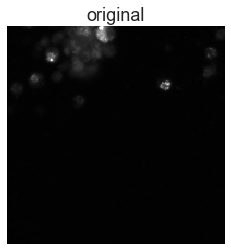

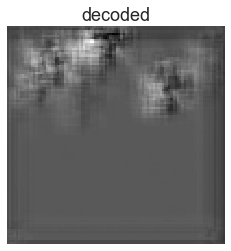

In [96]:
show_image(reshape(x_train[1], w=image_width, h=image_height), title="original")
#show_image(reshape(encoded_imgs[11], w=100, h=100), title="encoded")
show_image(reshape(decoded_imgs[0], w=image_width, h=image_height), title="decoded")

### TODO
* Tune autoencoder to get dimensionality reduction + good results!
* Fit training dataset to model
* Predict x_test
* Calculate overlap
* Follow t-sne tutorial; read on parameters; adapt for the task
* Same for UMAP
* Fit_transform overlapped compressed images in t-sne, then umap
* Hope for the best

### Calculate overlap between images

In [12]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, image_width*image_height), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        #o = reshape(np.abs(dcell-tcell))
        o = np.abs(dcell-tcell)
        overlaps[y] = o
        overlap_labels.append(labels[y])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(encoded_imgs, y_train)
#overlap, _ = calculate_overlap(x_test, y_test)

### TSNE code on own dataset

In [51]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(random_state=RS).fit_transform(x_overlap)

(<Figure size 576x576 with 1 Axes>,
 [Text(4.975341, -10.336546, '0'),
  Text(-12.279524, 24.514067, '1'),
  Text(4.2586923, -9.231358, '2'),
  Text(4.6639204, -9.599739, '3')])

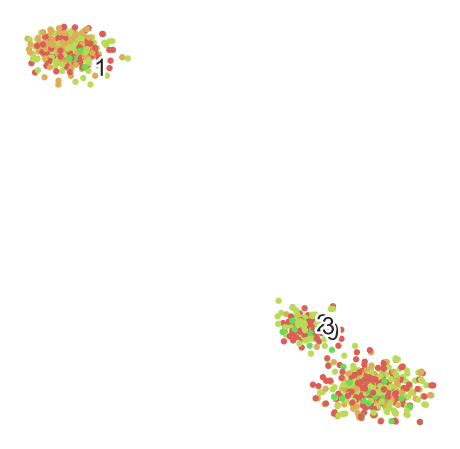

In [60]:
scatter(tsne, y_overlap)

In [25]:
x_dmso = np.reshape(x_)

(196, 200, 200, 1)

In [23]:
import umap.umap_ as umap
reducer = umap.UMAP()
embeddings = reducer.fit_transform(DMSO_dataset)

ValueError: Found array with dim 3. Estimator expected <= 2.

(<Figure size 576x576 with 1 Axes>,
 [Text(-2.2661724, 1.0799658, '0'),
  Text(12.14735, 0.79522675, '1'),
  Text(-2.1294107, 1.0460321, '2'),
  Text(-2.330204, 1.6459184, '3')])

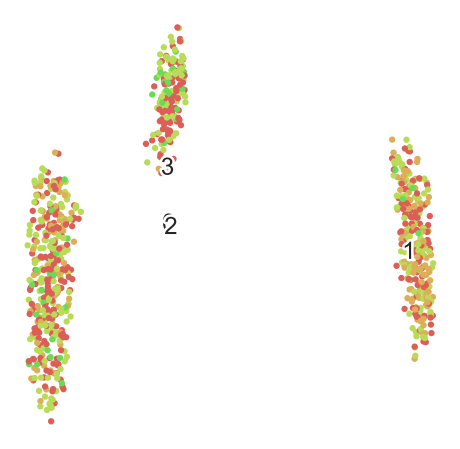

In [18]:
scatter(embeddings, y_overlap)

### View filters; code snippets

In [ ]:
num_classes

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1

### Run own code on MNIST dataset

In [7]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RS = 20191458

Using TensorFlow backend.


In [36]:
(x_train, y_train), (x_test, _) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [13]:
compressed_digits = encoder.predict(x_train)

In [15]:
x_sample, y_sample = compressed_digits[:1000], y_train[:1000]

In [16]:
digits_proj = TSNE(random_state=RS).fit_transform(x_sample)

(<Figure size 576x576 with 1 Axes>,
 [Text(-23.434824, -24.07652, '0'),
  Text(0.8921342, 36.784325, '1'),
  Text(-3.4372888, -14.56851, '2'),
  Text(-18.846968, -2.4877715, '3'),
  Text(24.522135, -7.741519, '4'),
  Text(-12.719883, 4.7274294, '5'),
  Text(2.67167, -32.721523, '6'),
  Text(25.147923, 17.10795, '7'),
  Text(-26.502972, 13.967726, '8'),
  Text(21.978443, 4.1691303, '9')])

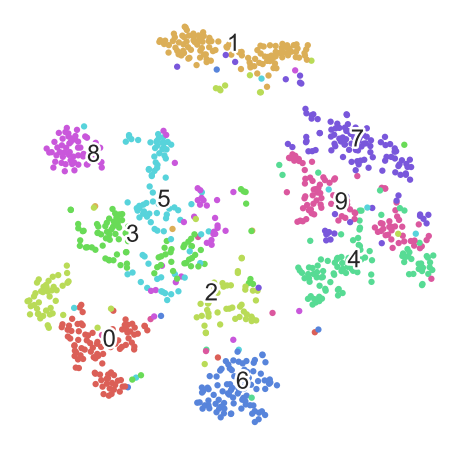

In [18]:
scatter(digits_proj, y_sample)